# Dont' use features that require transform to res variables with celmech in tseries. Almost as good as models that include them

In [15]:
import numpy as np
#import sklearn
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
from sklearn import metrics
import xgboost as xgb
from xgboost.sklearn import XGBClassifier
from hyperopt import hp, fmin, tpe, STATUS_OK, Trials
import hyperopt
import dill
import sys
sys.path.append('../spock/')
from modelfitting import train_test_split, ROC_curve, stable_unstable_hist, calibration_plot, unstable_error_fraction

In [16]:
datapath = '../training_data/'
dset = 'resonant/'
Norbits = 1e4
Nout = 80
featurefolder = 'spock_featuresNorbits{0:.1f}Nout{1}trio/'.format(Norbits, Nout)
trainingdatafolder = datapath+dset+featurefolder

In [10]:
model = XGBClassifier()
model.load_model(datapath+'../models/spockAMDstd.bin')

In [ ]:
dataset = pd.read_csv(trainingdatafolder+"trainingdata.csv", index_col = 0)
#AMD = ['AMDtriofracnear', 'AMDtriofracfar']
megno = ['MEGNO', 'MEGNOstd']
resparamfeatures = ['EMcrossnear', 'EMcrossfar', 'MMRstrengthnear', 'MMRstrengthfar']
tseriesshort = ['EPstdnear', 'EPstdfar', 'EMfracstdnear', 'EMfracstdfar']
features = AMD + tseriesshort + megno + resparamfeatures



In [11]:
preds = model.predict_proba(trainX)[:,1]

In [ ]:
df = pd.read_csv(trainingdatafolder+"trainingdata.csv", index_col = 0)
dfstable = 

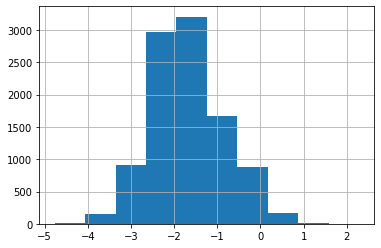

In [3]:
np.log10(df['AMDtriofracnear']).hist()

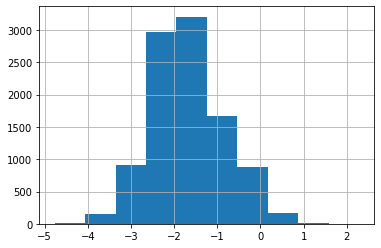

In [17]:
df = pd.read_csv(trainingdatafolder+"trainingdata.csv", index_col = 0)
np.log10(df['AMDtriofracnear']).hist()

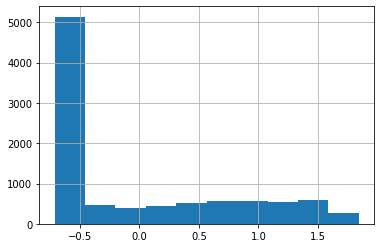

In [28]:
df = pd.read_csv(trainingdatafolder+"trainingdata.csv", index_col = 0)
np.log10(df['MEGNOstd']).hist()

In [17]:
space ={
        'max_depth': hp.randint('x_max_depth',  20),
        'min_child_weight': hp.quniform ('x_min_child', 1, 10, 1),
        'subsample': hp.uniform ('x_subsample', 0.8, 1),
        'scale_pos_weight': hp.uniform("x_pos_weight", 1, 50),
        "learning_rate":hp.uniform("x_learning_rate",0.01,0.2),
        'colsample_bytree': hp.uniform ('x_tree_colsample', 0.5,1),
}

def objective(params):
    clf = XGBClassifier(n_estimators = 100,
                            max_depth = params['max_depth'], 
                            min_child_weight = params['min_child_weight'],
                            subsample = params['subsample'],
                            colsample_bytree = params['colsample_bytree'],
                            learning_rate = params['learning_rate'], seed = 0)
    
    score = xgb.cv(clf.get_xgb_params(), dtrain, nfold = 5, metrics = "auc", early_stopping_rounds=10)
    avg_score =  np.mean(score["test-auc-mean"])
    error = np.mean(score["test-auc-std"])
    
    print("SCORE:", avg_score, "ERROR", error)#, "HOLDOUT SCORE", test_score)
    return{'loss':1-avg_score, 'status': STATUS_OK, "cv_score":avg_score , "cv_error":error}

In [18]:
Norbits = 1e4

AMD = ['AMDtriofracnear', 'AMDtriofracfar']
megno = ['MEGNO', 'MEGNOstd']
resparamfeatures = ['EMcrossnear', 'EMcrossfar', 'MMRstrengthnear', 'MMRstrengthfar']
tseriesshort = ['EPstdnear', 'EPstdfar', 'EMfracstdnear', 'EMfracstdfar']

features = tseriesshort + megno + resparamfeatures

trainX, trainY, testX, testY = train_test_split(trainingdatafolder, features, filter=False)

dtrain = xgb.DMatrix(trainX, trainY)
dtest = xgb.DMatrix(testX, testY)

/home/dtamayo/miniconda3/envs/ml/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/dtamayo/miniconda3/envs/ml/lib/python3.7/site-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


In [19]:
%%time
trials = Trials()
import time
start = time.time()
best = fmin(fn=objective, space = space, algo = tpe.suggest, max_evals = 50, trials = trials, rstate=np.random.RandomState(seed=0))
end = time.time()
print("Optimization Time: %f seconds", (end  -start))

SCORE:                                              
0.92202308                                          
ERROR                                               
0.004253700444631274                                
SCORE:                                                               
0.9237668000000001                                                   
ERROR                                                                
0.005313263228233581                                                 
SCORE:                                                                        
0.8510574400000002                                                            
ERROR                                                                         
0.009707187576998188                                                          
SCORE:                                                                        
0.91003472                                                                    
ERROR                             

SCORE:                                                                         
0.9257164                                                                      
ERROR                                                                          
0.0038915861667480752                                                          
SCORE:                                                                         
0.9190957599999999                                                             
ERROR                                                                          
0.003231259497198388                                                           
SCORE:                                                                         
0.9232378600000001                                                             
ERROR                                                                          
0.0027650461966536883                                                          
SCORE:                                  

In [20]:
best

{'x_learning_rate': 0.1677980967438641,
 'x_max_depth': 15,
 'x_min_child': 7.0,
 'x_pos_weight': 26.85488857035793,
 'x_subsample': 0.8679248628527879,
 'x_tree_colsample': 0.855078939499289}

# Would have to set num_boost_round=100 to see the same CV score as in our final fitted model

We're setting n_estimators=100 in model, which is the equivalent of num_boost_round in CV, so if we use the default in CV (10), we will get slightly lower powerformance

In [21]:
model = XGBClassifier(n_estimators=100, scale_pos_weight=best["x_pos_weight"],
                         learning_rate = best["x_learning_rate"], 
                         max_depth = int(best["x_max_depth"]), 
                         min_child_weight = best["x_min_child"],
                         subsample = best["x_subsample"], 
                         colsample_bytree = best["x_tree_colsample"])

score = xgb.cv(model.get_xgb_params(), dtrain, nfold = 5, metrics = "auc", verbose_eval=True, num_boost_round=10)
model.fit(trainX, trainY)

[0]	train-auc:0.936769+0.00124071	test-auc:0.901401+0.00666475
[1]	train-auc:0.952608+0.00229058	test-auc:0.911169+0.00522098
[2]	train-auc:0.960471+0.0028849	test-auc:0.915592+0.00591057
[3]	train-auc:0.968299+0.00215922	test-auc:0.920622+0.00474316
[4]	train-auc:0.972465+0.00103892	test-auc:0.922277+0.00588732
[5]	train-auc:0.975043+0.00100842	test-auc:0.92436+0.00604379
[6]	train-auc:0.97729+0.00093079	test-auc:0.926401+0.00589218
[7]	train-auc:0.97858+0.00132438	test-auc:0.926726+0.0054043
[8]	train-auc:0.980245+0.000952457	test-auc:0.927747+0.00573154
[9]	train-auc:0.982149+0.00105664	test-auc:0.929011+0.00502965


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bytree=0.855078939499289, gamma=0,
              learning_rate=0.1677980967438641, max_delta_step=0, max_depth=15,
              min_child_weight=7.0, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=26.85488857035793,
              seed=None, silent=True, subsample=0.8679248628527879)

In [25]:
model.save_model(datapath+'../models/spocknoAMD2.bin')

In [23]:
dill.dump([model, features, featurefolder], open(datapath+"../models/spocknoAMD2.pkl", "wb"))

In [16]:
model, features, featurefolder = dill.load(open(datapath+"../models/spock.pkl", "rb"))

In [13]:
model = XGBClassifier()
model.load_model(datapath+'../models/spockAMDstd.bin')

# SPOCK

Text(0.5, 1.0, 'ROC curve (AUC = 0.930)')

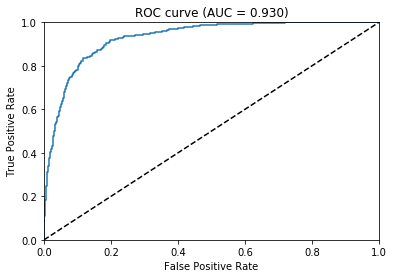

In [22]:
#model, features, featurefolder = dill.load(open(modelpath+filename+'.pkl', "rb"))
#testingdatafolder = datapath+testing_dataset+'/'+featurefolder
#roc_auc, fpr, tpr, ROCthresholds = ROC_curve(testingdatafolder, model, features, filtertimes=True)

roc_auc, fpr, tpr, ROCthresholds = ROC_curve(trainingdatafolder, model, features)

fig, ax = plt.subplots()
ax.plot(fpr, tpr)
ax.plot([0, 1], [0, 1], 'k--')
ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.0])
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title('ROC curve (AUC = {0:.3f})'.format(roc_auc))

Text(0.5, 1.0, 'ROC curve (AUC = 0.933)')

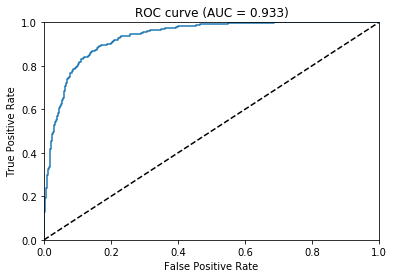

In [13]:
#model, features, featurefolder = dill.load(open(modelpath+filename+'.pkl', "rb"))
#testingdatafolder = datapath+testing_dataset+'/'+featurefolder
#roc_auc, fpr, tpr, ROCthresholds = ROC_curve(testingdatafolder, model, features, filtertimes=True)

roc_auc, fpr, tpr, ROCthresholds = ROC_curve(trainingdatafolder, model, features)

fig, ax = plt.subplots()
ax.plot(fpr, tpr)
ax.plot([0, 1], [0, 1], 'k--')
ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.0])
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title('ROC curve (AUC = {0:.3f})'.format(roc_auc))

Text(0.5, 1.0, 'ROC curve (AUC = 0.953)')

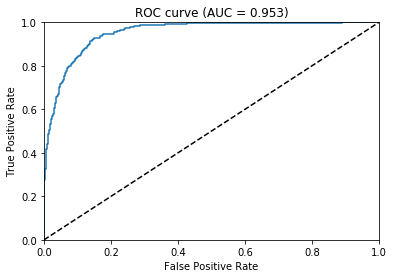

In [9]:
#model, features, featurefolder = dill.load(open(modelpath+filename+'.pkl', "rb"))
#testingdatafolder = datapath+testing_dataset+'/'+featurefolder
#roc_auc, fpr, tpr, ROCthresholds = ROC_curve(testingdatafolder, model, features, filtertimes=True)

roc_auc, fpr, tpr, ROCthresholds = ROC_curve(trainingdatafolder, model, features)

fig, ax = plt.subplots()
ax.plot(fpr, tpr)
ax.plot([0, 1], [0, 1], 'k--')
ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.0])
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title('ROC curve (AUC = {0:.3f})'.format(roc_auc))

Text(0.5, 1.0, 'ROC curve (AUC = 0.954)')

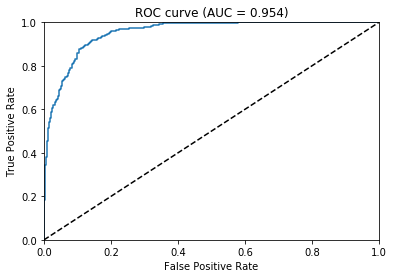

In [8]:
#model, features, featurefolder = dill.load(open(modelpath+filename+'.pkl', "rb"))
#testingdatafolder = datapath+testing_dataset+'/'+featurefolder
#roc_auc, fpr, tpr, ROCthresholds = ROC_curve(testingdatafolder, model, features, filtertimes=True)

roc_auc, fpr, tpr, ROCthresholds = ROC_curve(trainingdatafolder, model, features)

fig, ax = plt.subplots()
ax.plot(fpr, tpr)
ax.plot([0, 1], [0, 1], 'k--')
ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.0])
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title('ROC curve (AUC = {0:.3f})'.format(roc_auc))

Text(0.5, 1.0, 'ROC curve (AUC = 0.954)')

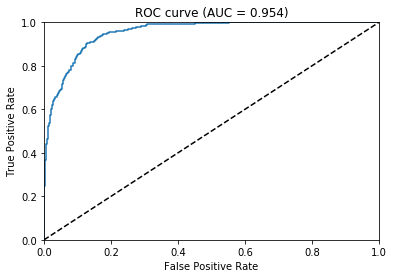

In [10]:
#model, features, featurefolder = dill.load(open(modelpath+filename+'.pkl', "rb"))
#testingdatafolder = datapath+testing_dataset+'/'+featurefolder
#roc_auc, fpr, tpr, ROCthresholds = ROC_curve(testingdatafolder, model, features, filtertimes=True)

roc_auc, fpr, tpr, ROCthresholds = ROC_curve(trainingdatafolder, model, features)

fig, ax = plt.subplots()
ax.plot(fpr, tpr)
ax.plot([0, 1], [0, 1], 'k--')
ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.0])
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title('ROC curve (AUC = {0:.3f})'.format(roc_auc))

In [13]:
for i in range(0,len(tpr), 15):
    print("Threshold {0}, TPR = {1}, FPR = {2}".format(ROCthresholds[i], tpr[i], fpr[i]))

Threshold 1.9999518394470215, TPR = 0.0, FPR = 0.0
Threshold 0.9963535070419312, TPR = 0.32717190388170053, FPR = 0.00616860863605209
Threshold 0.9940648674964905, TPR = 0.39926062846580407, FPR = 0.011651816312542838
Threshold 0.9906452894210815, TPR = 0.4436229205175601, FPR = 0.019876627827278958
Threshold 0.9820418357849121, TPR = 0.5415896487985212, FPR = 0.02467443454420836
Threshold 0.9707850813865662, TPR = 0.6136783733826248, FPR = 0.03015764222069911
Threshold 0.9615837931632996, TPR = 0.634011090573013, FPR = 0.0411240575736806
Threshold 0.9437741041183472, TPR = 0.6617375231053605, FPR = 0.047978067169294036
Threshold 0.9169477224349976, TPR = 0.7060998151571165, FPR = 0.05757368060315284
Threshold 0.893177330493927, TPR = 0.7282809611829945, FPR = 0.06854009595613433
Threshold 0.8452789187431335, TPR = 0.7504621072088724, FPR = 0.08087731322823852
Threshold 0.7959820628166199, TPR = 0.7929759704251387, FPR = 0.09184372858122002
Threshold 0.7434535622596741, TPR = 0.8114602

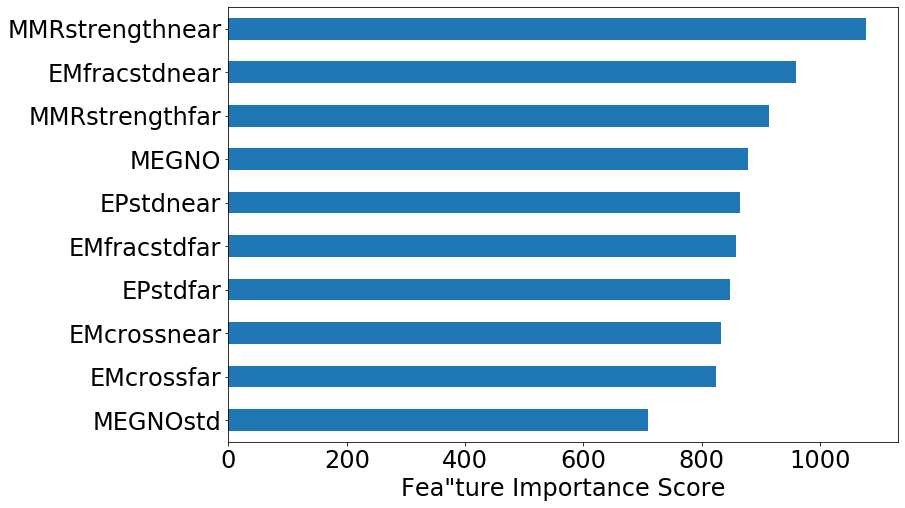

In [14]:
# feature importances
feat_imp = pd.Series(model.get_booster().get_fscore()).sort_values(ascending=False)
ax = feat_imp.plot.barh(figsize=(12,8), fontsize=24)
ax.set_xlabel('Fea"ture Importance Score', fontsize=24)
ax.invert_yaxis()
plt.savefig('featureimportances.pdf', bbox_inches='tight')

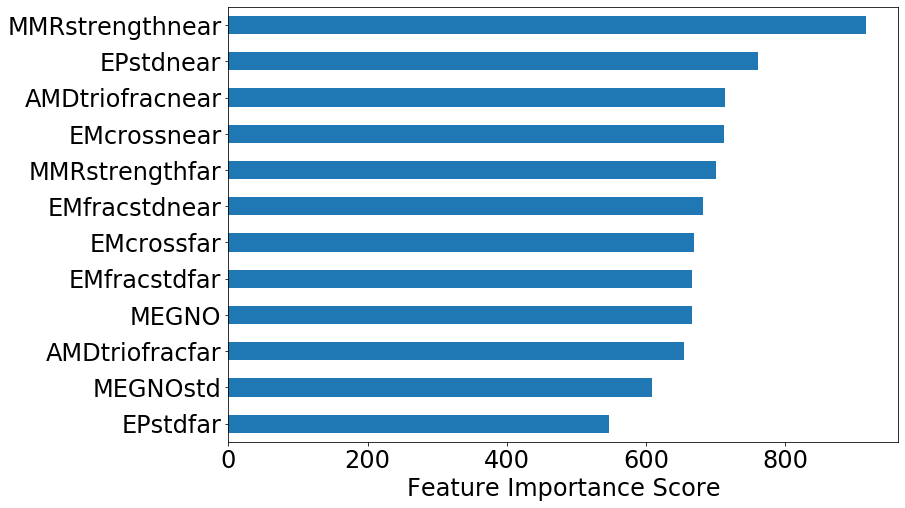

In [9]:
# feature importances
feat_imp = pd.Series(model.get_booster().get_fscore()).sort_values(ascending=False)
ax = feat_imp.plot.barh(figsize=(12,8), fontsize=24)
ax.set_xlabel('Feature Importance Score', fontsize=24)
ax.invert_yaxis()
plt.savefig('featureimportances.pdf', bbox_inches='tight')

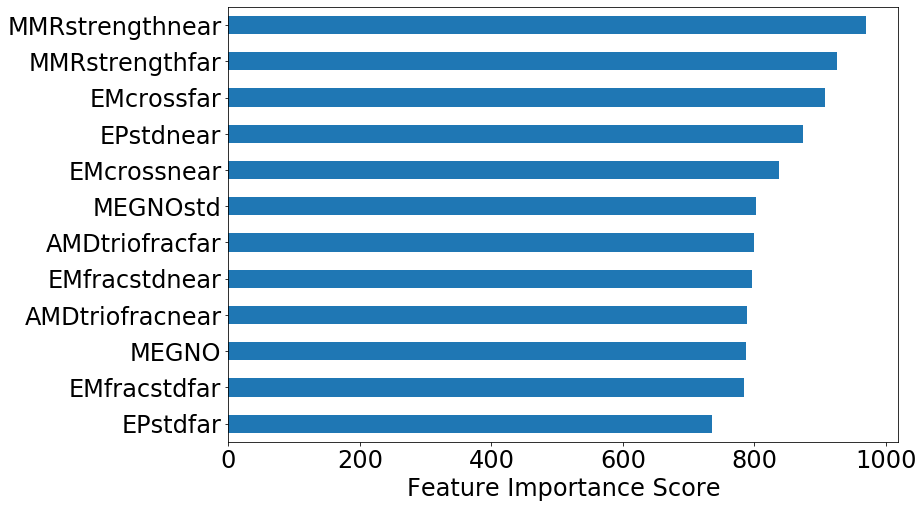

In [18]:
# feature importances
feat_imp = pd.Series(model.get_booster().get_fscore()).sort_values(ascending=False)
ax = feat_imp.plot.barh(figsize=(12,8), fontsize=24)
ax.set_xlabel('Feature Importance Score', fontsize=24)
ax.invert_yaxis()
plt.savefig('featureimportances.pdf', bbox_inches='tight')

In [16]:
feat_imp

MMRstrengthnear    970
MMRstrengthfar     926
EMcrossfar         908
EPstdnear          874
EMcrossnear        838
MEGNOstd           802
AMDtriofracfar     799
EMfracstdnear      796
AMDtriofracnear    789
MEGNO              787
EMfracstdfar       784
EPstdfar           735
dtype: int64

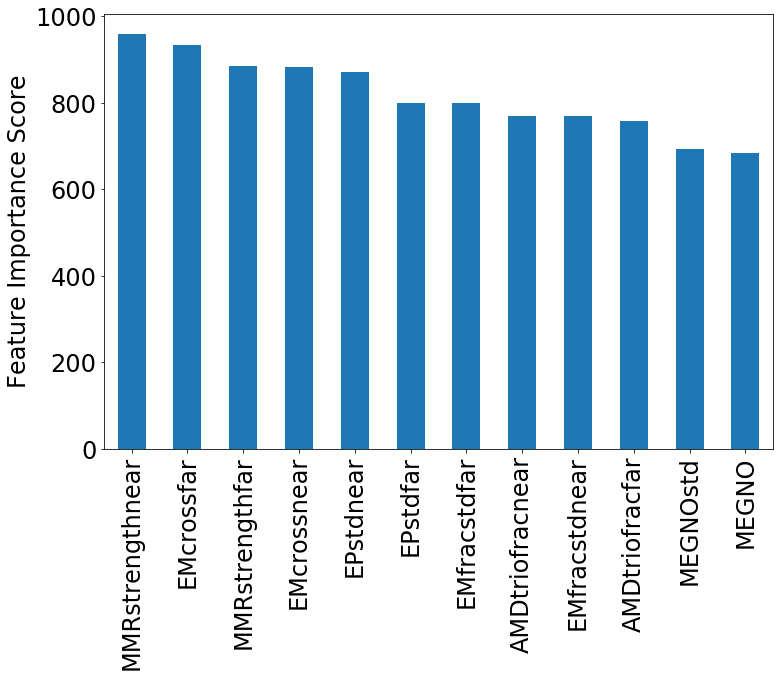

In [19]:
# feature importances
feat_imp = pd.Series(model.get_booster().get_fscore()).sort_values(ascending=False)
feat_imp.plot(kind='bar', figsize=(12,8),  fontsize=24)
plt.ylabel('Feature Importance Score', fontsize=24)
plt.savefig('featureimportances.pdf', bbox_inches='tight')

(0, 179.3)

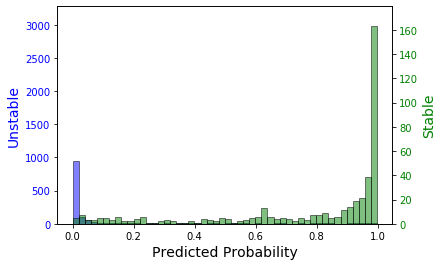

In [21]:
# Histogram:
bins = 50
Stable, Unstable = stable_unstable_hist(trainingdatafolder, model, features)

fig, ax1 = plt.subplots()
n, bins, pathces = ax1.hist(Unstable, bins, alpha=0.5, label='No', color='blue', edgecolor = "black")
#print(n)
ax1.set_xlabel('Predicted Probability', fontsize=14)
ax1.set_ylabel('Unstable',  fontsize=14, color='blue')
for tl in ax1.get_yticklabels():
    tl.set_color('blue')
    


ax2 = ax1.twinx()
n, bins , patches = ax2.hist(Stable, bins, alpha=0.5, label='Yes',color='green', edgecolor = "black")
#print(n.astype(int))
ax2.set_ylabel('Stable', fontsize=14, color='green')
for tl in ax2.get_yticklabels():
    tl.set_color('green')
    
    
#ax1.set_ylim(ax2.get_ylim())
ax1.set_ylim([0,20.1*n[-1]]) # goes up to ~4300
ax2.set_ylim([0,1.1*n[-1]]) # goes up to ~2100

Text(0, 0.5, 'Fraction actually stable')

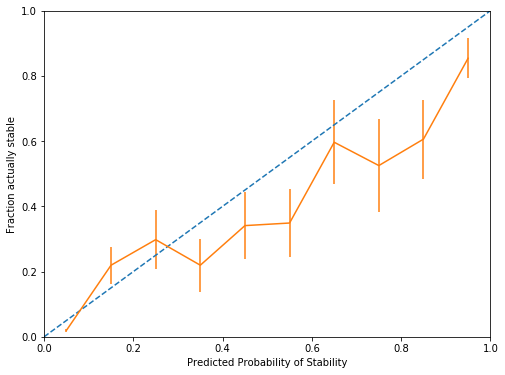

In [22]:
bincenters, fracstable, errorbars = calibration_plot(trainingdatafolder, model, features, bins=10)
fig, ax = plt.subplots(figsize=(8,6))
ax.plot(np.linspace(0,1,100), np.linspace(0,1,100), '--')
ax.errorbar(bincenters, fracstable, errorbars)
ax.set_xlim([0,1])
ax.set_ylim([0,1])
ax.set_xlabel('Predicted Probability of Stability')
ax.set_ylabel('Fraction actually stable')

Text(0.5, 1.0, 'Fraction of unstable systems mislabeled as stable')

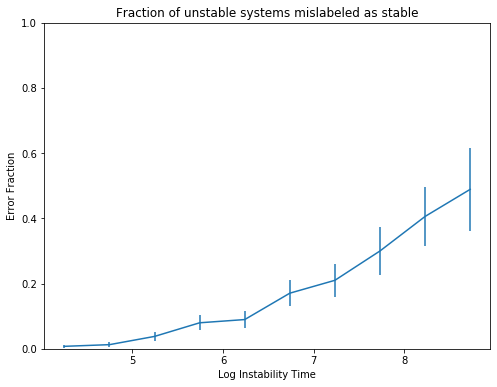

In [23]:
bincenters, errorfracs, errorbars = unstable_error_fraction(trainingdatafolder, model, features, bins=10)
fig, ax = plt.subplots(figsize=(8,6))
ax.errorbar(bincenters, errorfracs, errorbars)
ax.set_ylim([0,1])
ax.set_xlabel('Log Instability Time')
ax.set_ylabel('Error Fraction')
ax.set_title('Fraction of unstable systems mislabeled as stable')